<h1 align='center'> Titanic - Machine Learning from Disaster </h1>
<h4 align='center'> Predict survival on the Titanic and get familiar with ML basics </h4>

### The Challenge
**The sinking of the Titanic is one of the most infamous shipwrecks in history.**

**On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg.** **Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.**

**While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.**

**In this challenge, we are to build a predictive model that answers the question: "What sorts of people were more likely to survive"** **using passenger data (ie name, age, gender, socio-economic class, etc).**

## 0. Import relevant Dependencies

Incase you are getting any error saying the package is not installed while running the below cell, then you can use two methods:
- pip install ________.
- google 'How to install ________.

In [1]:
# Import Dependencies -To see the graphs in the notebook.
%matplotlib inline   

# Python Imports
import math,time,random,datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization -This is where the graphs come in.
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
plt.style.use('fivethirtyeight')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine Learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Loading the required Data

> I have kept my data in a folder called "TITANIC" which is then again kept in a folder called "DATA".

In [2]:
# Import the train and test data.
train = pd.read_csv('DATA/TITANIC/train.csv')
test = pd.read_csv('DATA/TITANIC/test.csv')
gender_submission = pd.read_csv('DATA/TITANIC/gender_submission.csv')

In [3]:
# Viewing the train dataset
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Viewing the test dataset
test.head() #head = view first 5 rows

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


> - As you can see here the train dataset have a 'Survived' column but out test dataset does'nt have one. So what we have to do is build a Machine Learning model that is able to learn from the train dataset and predict the 'Survived' column on the test dataset.

In [5]:
# This is how our end submission is gonna look like.
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [6]:
print("Length of the train dataset: ", len(train))
print("Dimensionality of the test dataset: ", test.shape)

Length of the train dataset:  891
Dimensionality of the test dataset:  (418, 11)


### Data Dictionary

- **Survival: ** 0 = No, 1 = Yes

- **pclass (Ticket class): ** 1 = 1st class, 2 = 2nd class, 3 = 3rd class

- **Sex** 

- **Age (in years)**

- **sibsp: **	number of siblings / spouses aboard the Titanic

- **parch: **	number of parents / children aboard the Titanic	

- **ticket: ** Ticket number	

- **fare: ** Passenger fare

- **cabin: **	Cabin number

- **embarked (Port of Embarkation): ** C = Cherbourg, Q = Queenstown, S = Southampton

## 2. Exploratory Data Analysis

**PROBLEM: ** To predict whether is a particular person survived based on the information provided in the test dataset.

In [7]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


> - Here we can see that the count of the 'Age' column is 714 which might mean that there are some missing values.

### Missing Values

- In any dataset we will initially try to find out where the missing data are. 

<AxesSubplot:>

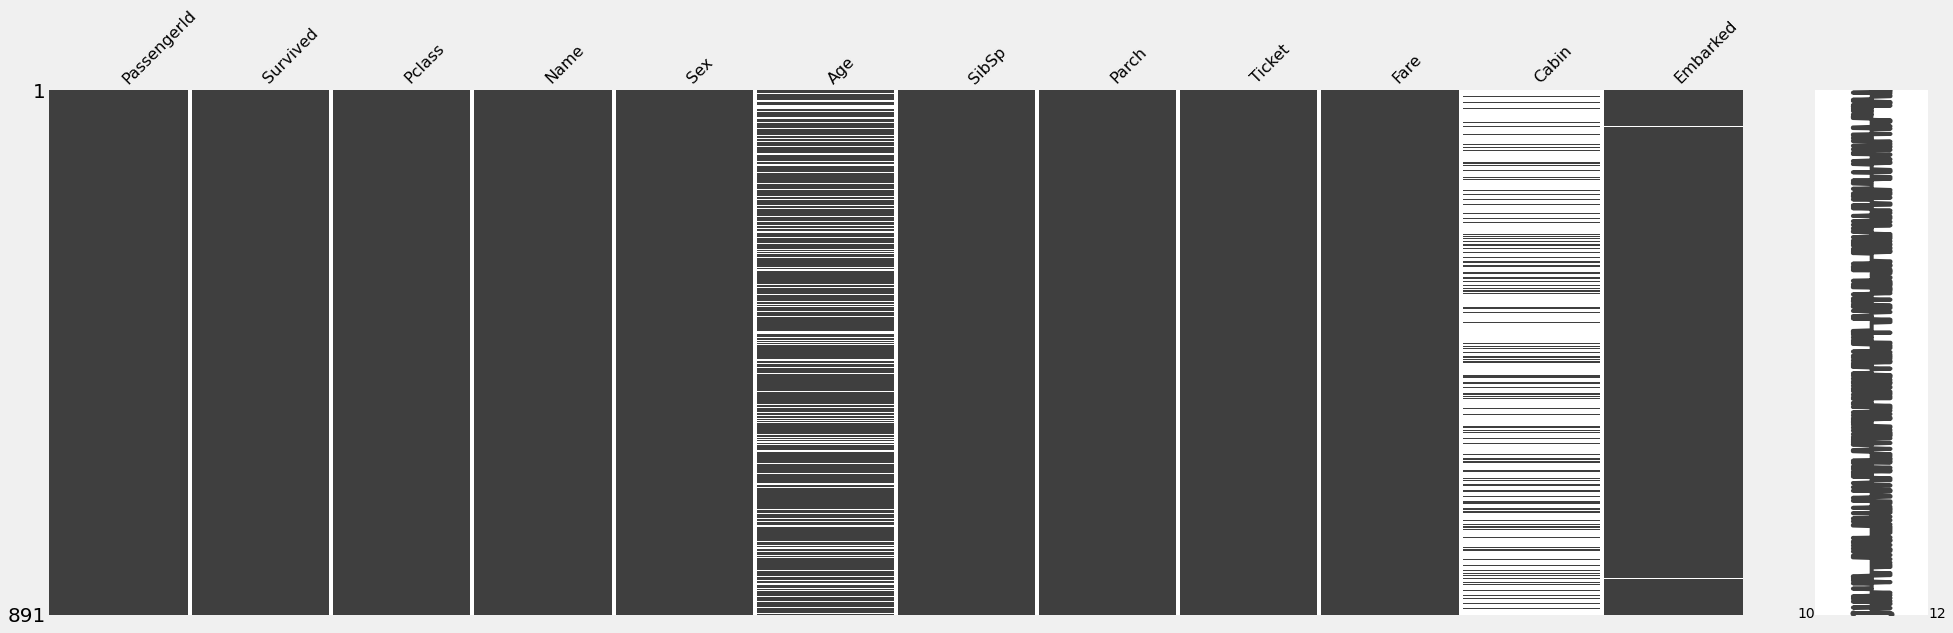

In [8]:
# To plot a graphic of missing values
missingno.matrix(train,figsize=(30,9))

- It is important to visualise missing values, because then you will know what are the major NaN values in your dataset.
- Here we can see that out 'Cabin' column has quite a few missing values.

In [9]:
# Another method to find missing values
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Create two new dataframes to perform our Data Analysis.

Keep one for exploring discretised continuous variables (continuous variable which have been sorted into some kind of category) and another for exploring continuous variables. 

- **Continuous Variables: ** 0-100 (Here there is no break in between)

- **Discretised Continuous Variables: ** 0-10, 10-20, ..... ,90-100 (Here we are putting them into different bins or intervals)

We are separating the data so that we can run different types of models over each dataframe.

In [10]:
df_dis = pd.DataFrame() #For discretised continuous variables 
df_con = pd.DataFrame() #For continuous variables 

### What Datatypes are there in the dataframe?

We usually consider features with a datatype of object as categorical features. And those with float or int could be numerical features.

However, sometimes the features that we consider as numerical might actually turn out to be categorical.

The next few steps will help us figure out how to process our data so our machine learning model can learn from it.
Ideally all the features will be encoded into a numerical value of some kind (maybe 0 or 1 / something else).

In [11]:
# Datatypes in the dataset
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

### Exploring each of these features 
We will go through each of the columns and see which all we can use in our first models. Some of them needs more preprocessing than the others to get ready.

In [12]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### FEATURE 1: Survived
Description: Whether the passenger survived or not.

Key: 0 = did not survive, 1 = survive

***This is the variable we want our ML model to predict based off the others.***

0    549
1    342
Name: Survived, dtype: int64


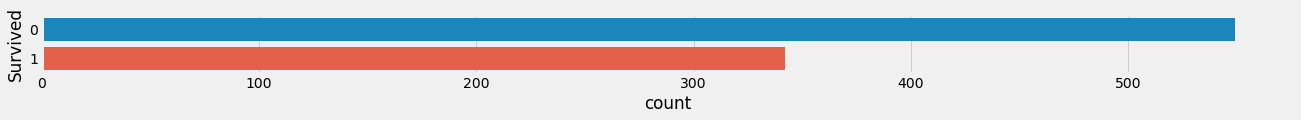

In [13]:
# How many people has survived the titanic?
fig = plt.figure(figsize=(20,1))
sns.countplot(y='Survived',data=train)
#sns.countplot(x='Survived',data=train)             --> You can use this to get a vertical graph.
 
print(train['Survived'].value_counts())             ##This will help us see the exact number along with the graph.

- So here we can see that the people who survived (342) are far less than the ones who did'nt (549). Thus, in the future when we run our test dataset and we get that the number of people who survived is more then that means that there something wrong.

In [14]:
# Let's add the 'Survived' column to our subset dataframes.
df_dis['Survived'] = train['Survived']
df_con['Survived'] = train['Survived']

In [15]:
print('df_dis \n',df_dis.head())
print('')
print('')
print('df_con \n',df_con.head())

df_dis 
    Survived
0         0
1         1
2         1
3         1
4         0


df_con 
    Survived
0         0
1         1
2         1
3         1
4         0


The two subset dataframe have the similar value as of now.

#### FEATURE 2: Pclass
Description: The ticket class of each passenger.

Key: 1 = 1st class, 2 = 2nd class, 3 = 3rd class

- #### Let's plot the Distribution
Why? We will look at the distribution of each feature to understand the spread there is actoss the dataset.

**For example: ** If the values are completely outside the distribution, then we may not want to include them in the model.

<AxesSubplot:xlabel='Pclass', ylabel='Density'>

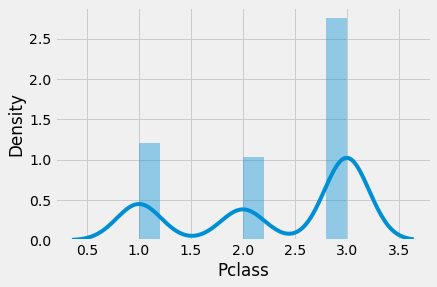

In [16]:
# .distplot tells us the distribution of a feature.
sns.distplot(train['Pclass'])

Here with this particular feature, the values are numerical (1, 2 and 3), but they are also categories.
- Because a person in 3rd class doesn't necessarily equal a passenger in 2nd class + 1st class. (This doesn't make sense dose it?)

In [17]:
# How many missing values are there in Pclass
train['Pclass'].isnull().sum()

0

Since there are no missing values we will add 'Pclass' column to our subset dataframes. This is our first feature which is not a predictive variable.

In [18]:
df_dis['Pclass'] = train['Pclass']
df_con['Pclass'] = train['Pclass']

In [19]:
print('df_dis \n',df_dis.head())
print('')
print('')
print('df_con \n',df_con.head())

df_dis 
    Survived  Pclass
0         0       3
1         1       1
2         1       3
3         1       1
4         0       3


df_con 
    Survived  Pclass
0         0       3
1         1       1
2         1       3
3         1       1
4         0       3


#### FEATURE 3: Name
Description: The name of the passenger.

In [20]:
# How many different names are there?
train['Name'].value_counts()[:15]      #--> This can be used to view the different types of names (here we are taking the first 15).
#train['Name'].count()                  --> This is required only if you want to get the total number of names.

Meanwell, Miss. (Marion Ogden)                     1
Maioni, Miss. Roberta                              1
Stankovic, Mr. Ivan                                1
Albimona, Mr. Nassef Cassem                        1
Giglio, Mr. Victor                                 1
Hippach, Mrs. Louis Albert (Ida Sophia Fischer)    1
Skoog, Master. Karl Thorsten                       1
Vovk, Mr. Janko                                    1
Salonen, Mr. Johan Werner                          1
Scanlan, Mr. James                                 1
Lahoud, Mr. Sarkis                                 1
Kilgannon, Mr. Thomas J                            1
Najib, Miss. Adele Kiamie "Jane"                   1
Charters, Mr. David                                1
Willey, Mr. Edward                                 1
Name: Name, dtype: int64

Every row has a unique name. This is similar to the passenger ID.

**Note: ** Because of so many different names we won't be using the name variable

#### FEATURE 4: Sex
Description: The gender of the passenger (male or female).

male      577
female    314
Name: Sex, dtype: int64


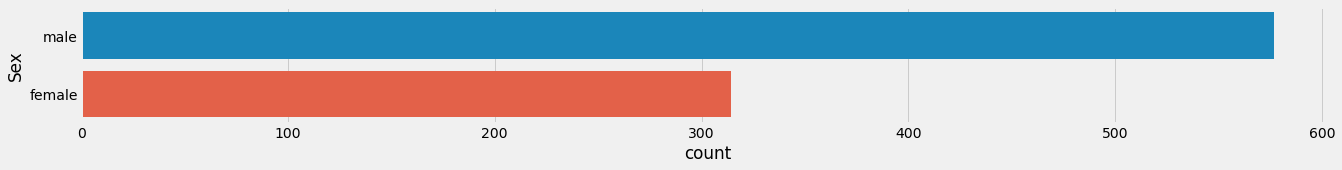

In [21]:
plt.figure(figsize=(20,2))
sns.countplot(y='Sex',data=train)
print(train['Sex'].value_counts())

In [22]:
# Are there any missing values?
train['Sex'].isnull().sum()
#train['Sex'].isnull().any()            --> This will give a boolean answer.

0

Since this is already a binary variable we can add this to our subset dataframes

In [23]:
# Add the Sex column to our df_dis dataframe.
df_dis['Sex'] = train['Sex']

# Now we will assign the female values in the df_dis dataframe the values 1 and the males 0.
df_dis['Sex'] = np.where(df_dis['Sex'] == 'female',1,0)

# Add the Sex column to our df_con dataframe.
df_con['Sex'] = train['Sex']

In [24]:
print('df_dis \n',df_dis.head())
print('')
print('')
print('df_con \n',df_con.head())

df_dis 
    Survived  Pclass  Sex
0         0       3    0
1         1       1    1
2         1       3    1
3         1       1    1
4         0       3    0


df_con 
    Survived  Pclass     Sex
0         0       3    male
1         1       1  female
2         1       3  female
3         1       1  female
4         0       3    male


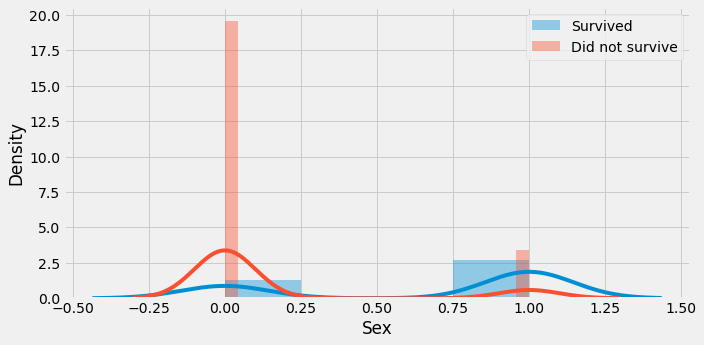

In [25]:
# Now let us compare the sex variable with the survival variable and see how it looks.
# This can be done because both are binarys (0 or 1).
fig = plt.figure(figsize=(10,5))
sns.distplot(df_dis.loc[df_dis['Survived'] == 1]['Sex'], label= 'Survived')
sns.distplot(df_dis.loc[df_dis['Survived'] == 0]['Sex'], label= 'Did not survive')
plt.legend()
plt.show()

- So from the above plot one thing we can understand is that, if you are a male on board the Titanic then your chances or survival is less. As it is seen that not most of the people survived but of those who did, more are females.

#### FEATURE 5: Age
Description: The age of each passenger.

In [26]:
# How many missing values are there in the Age column
train['Age'].isnull().sum()

177

> Out of a total of 891, 177 values are missing from the age column.
- How will we fill in these missing values?
- What will filling with mean do?
- Can we remove those rows completely?

#### FEATURE 6: SibSp
Description: The number of siblings or spouses aboard the Titanic.

In [27]:
# How many missing values are there in SibSp
train['SibSp'].isnull().sum()

0

In [28]:
# What values are present?
train['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

- We can see that most of the passengers on board the Titanic didn't have any spouse or sibling with them.

In [29]:
# Add SibSp to our sbset dataframes
df_dis['SibSp'] = train['SibSp']
df_con['SibSp'] = train['SibSp']

In [30]:
print('df_dis \n',df_dis.head())
print('')
print('')
print('df_con \n',df_con.head())

df_dis 
    Survived  Pclass  Sex  SibSp
0         0       3    0      1
1         1       1    1      1
2         1       3    1      0
3         1       1    1      1
4         0       3    0      0


df_con 
    Survived  Pclass     Sex  SibSp
0         0       3    male      1
1         1       1  female      1
2         1       3  female      0
3         1       1  female      1
4         0       3    male      0


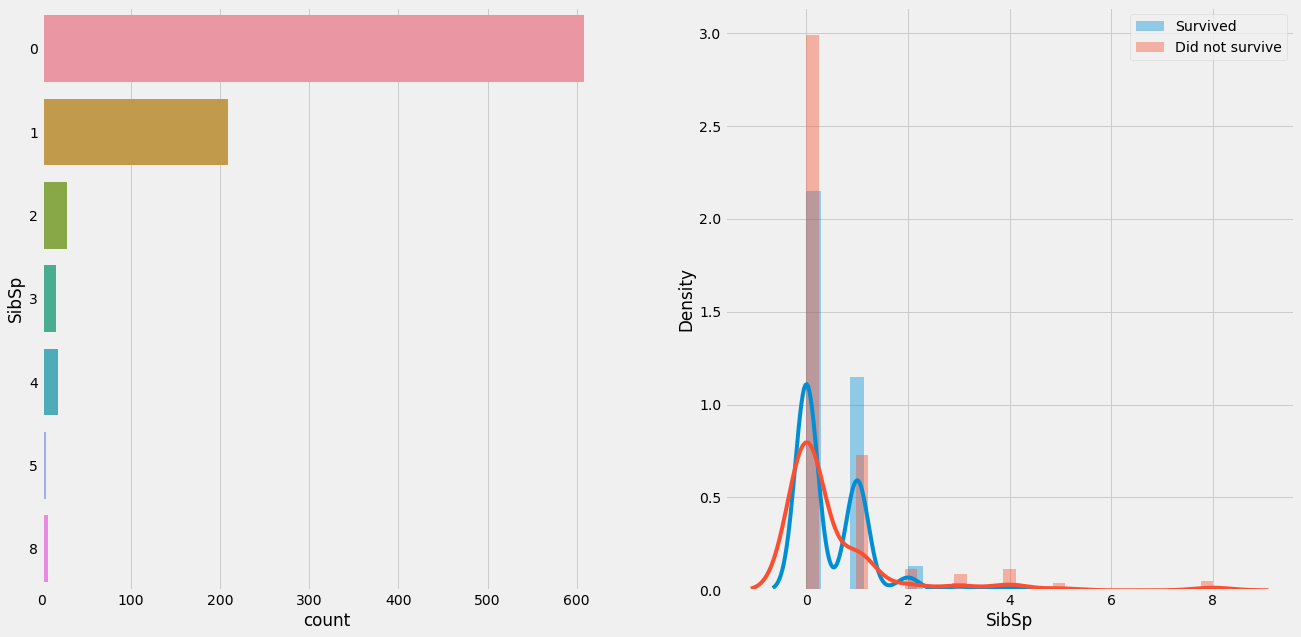

In [31]:
# Plot counts and distributions of Survived and SibSp variables side by side. 
fig = plt.figure(figsize= (20,10))

plt.subplot(1,2,1)
sns.countplot(y= 'SibSp', data= train)

plt.subplot(1,2,2)
sns.distplot(df_dis.loc[df_dis['Survived'] == 1]['SibSp'], label= 'Survived')
sns.distplot(df_dis.loc[df_dis['Survived'] == 0]['SibSp'], label= 'Did not survive')

plt.legend()
plt.show()

> We can see that the graph on the right is a count plot. 

> The graph on the left has more story to tell us.
- Here, those passengers who came alone had a low chance of survival (because of the ratio difference).
- But the passengers with one sibling or spouse has a higher chance of survival. This can be because if you had a wife onboard, your chances of survival can be high.

#### FEATURE 7: Parch
Description: The number of parents or children on board the Titanic.

- Since this is similar to SibSp, we will do a similar analysis.

In [32]:
# Is there any missing values are there in Parch
train['Parch'].isnull().any()

False

In [33]:
# What values are present?
train['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [34]:
# Add Parch to our sbset dataframes
df_dis['Parch'] = train['Parch']
df_con['Parch'] = train['Parch']

In [35]:
print('df_dis \n',df_dis.head())
print('')
print('')
print('df_con \n',df_con.head())

df_dis 
    Survived  Pclass  Sex  SibSp  Parch
0         0       3    0      1      0
1         1       1    1      1      0
2         1       3    1      0      0
3         1       1    1      1      0
4         0       3    0      0      0


df_con 
    Survived  Pclass     Sex  SibSp  Parch
0         0       3    male      1      0
1         1       1  female      1      0
2         1       3  female      0      0
3         1       1  female      1      0
4         0       3    male      0      0


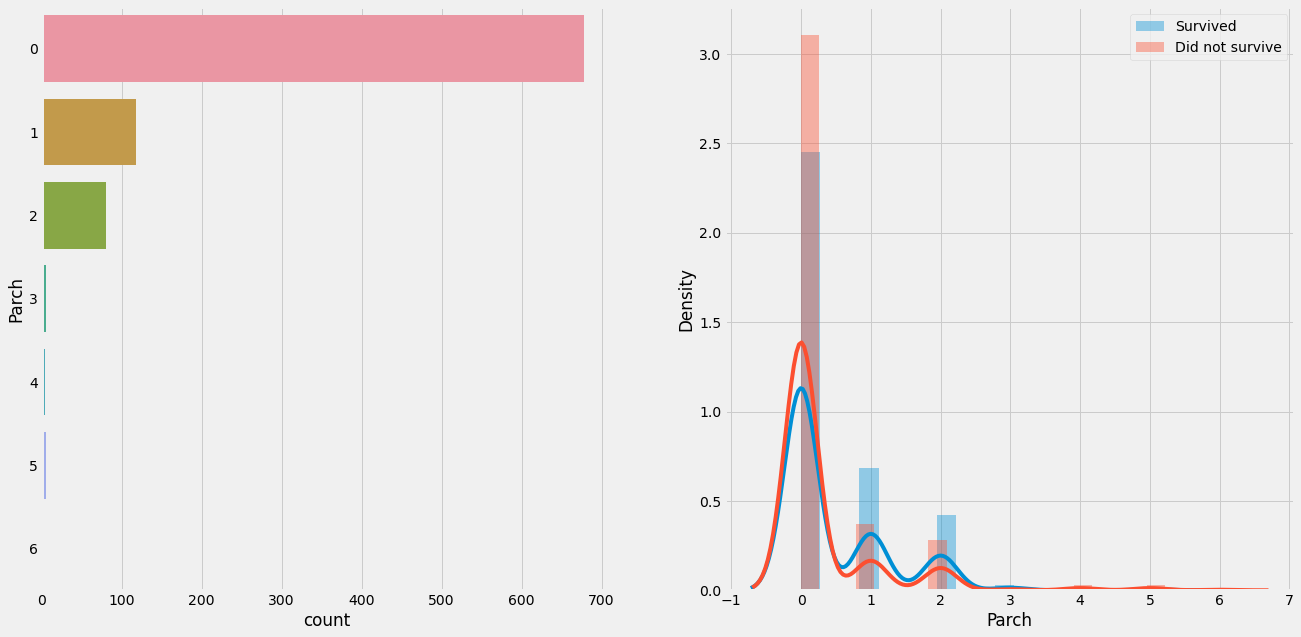

In [36]:
# Plot counts and distributions of Survived and Parch variables side by side. 
fig = plt.figure(figsize= (20,10))

plt.subplot(1,2,1)
sns.countplot(y= 'Parch', data= train)

plt.subplot(1,2,2)
sns.distplot(df_dis.loc[df_dis['Survived'] == 1]['Parch'], label= 'Survived')
sns.distplot(df_dis.loc[df_dis['Survived'] == 0]['Parch'], label= 'Did not survive')

plt.legend()
plt.show()

> We can see that the graph on the right is a count plot. 

> The graph on the left has more story to tell us.
- Here, those passengers who came alone had a low chance of survival (because of the ratio difference).
- But the passengers with one parent or child has a higher chance of survival. This can be because if you had a wife onboard, your chances of survival can be high.

#### FEATURE 8: Ticket
Description: The ticket number of each passenger.

In [37]:
# How many missing values are there in Ticket
train['Ticket'].isnull().sum()

0

<AxesSubplot:xlabel='count', ylabel='Ticket'>

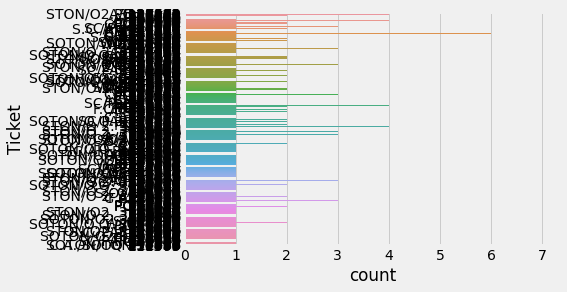

In [38]:
# How many different kinds of tickets did the passengers have?
sns.countplot(y= 'Ticket', data= train)

***Now this is hard to understand as there are many tickets. So we will look at a better way to view them.***

In [39]:
# How many different kinds of tickets did the passengers have?
train['Ticket'].value_counts()

CA. 2343              7
347082                7
1601                  7
CA 2144               6
347088                6
                     ..
STON/O 2. 3101286     1
364499                1
SOTON/O.Q. 3101306    1
349204                1
330932                1
Name: Ticket, Length: 681, dtype: int64

- So there is a total of 681 different tickets. Since this is too big we wont be using them in our subset dataframes.

#### FEATURE 9: Fare
Description: The cost of each ticket.

In [40]:
# How many missing values are there in Fare
train['Fare'].isnull().sum()

0

<AxesSubplot:xlabel='count', ylabel='Fare'>

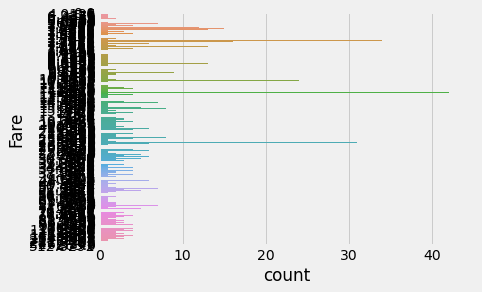

In [41]:
# How many different Fares the passengers paid? (Plot)
sns.countplot(y= 'Fare', data= train)

In [42]:
# What kind of variable is Fare?
train['Fare'].dtype

dtype('float64')

In [43]:
# How many unique kinds of Fares were there?
len(train['Fare'].unique())

248

- There are 248 unique Fare types.

Since our Fare is a float, let's add it to our continuous subset dataframe. But to add to the categorical subset dataframe we will be cutting it to bins.

In [44]:
# Add Fare to our sbset dataframes
df_con['Fare'] = train['Fare']                  # --> Continuous

df_dis['Fare'] = pd.cut(train['Fare'], bins= 4)  # --> Discretised

***Here we cut the Fare in discretised dataframe to equal bins using pd.cut***
- Check this link for better understanding https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html

In [45]:
print('df_dis \n',df_dis.head())
print('')
print('')
print('df_con \n',df_con.head())

df_dis 
    Survived  Pclass  Sex  SibSp  Parch               Fare
0         0       3    0      1      0  (-0.512, 128.082]
1         1       1    1      1      0  (-0.512, 128.082]
2         1       3    1      0      0  (-0.512, 128.082]
3         1       1    1      1      0  (-0.512, 128.082]
4         0       3    0      0      0  (-0.512, 128.082]


df_con 
    Survived  Pclass     Sex  SibSp  Parch     Fare
0         0       3    male      1      0   7.2500
1         1       1  female      1      0  71.2833
2         1       3  female      0      0   7.9250
3         1       1  female      1      0  53.1000
4         0       3    male      0      0   8.0500


- Here we can see that the fares for the discretised dataframe is between intervals. But there are negative values which can mean that there might be outliers that we might need to remove.

- In the continuous dataframe we can see the fare exactly as it is.

In [46]:
df_dis['Fare'].value_counts()

(-0.512, 128.082]     853
(128.082, 256.165]     29
(256.165, 384.247]      6
(384.247, 512.329]      3
Name: Fare, dtype: int64

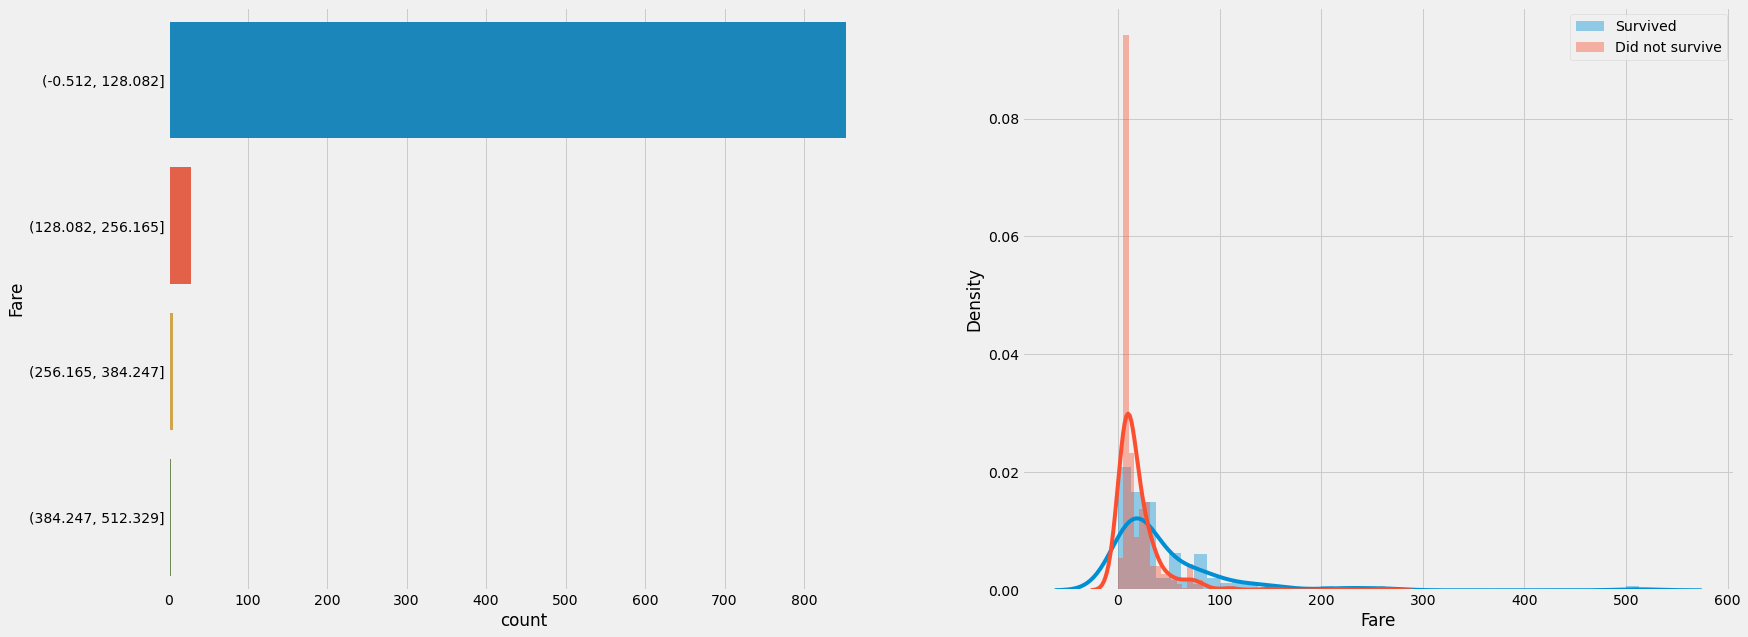

In [47]:
# Plot counts and distributions of Survived and Fare variables side by side. 
fig = plt.figure(figsize= (25,10))

plt.subplot(1,2,1)
sns.countplot(y= 'Fare', data= df_dis)

plt.subplot(1,2,2)
sns.distplot(train.loc[train['Survived'] == 1]['Fare'], label= 'Survived')
sns.distplot(train.loc[train['Survived'] == 0]['Fare'], label= 'Did not survive')

plt.legend()
plt.show()

- It looks like there is a more chance of survival for people whose fare charges was close to 100.

> Initially we kept the bins at 5, but then since there was a bin where no value was there we reduced it. So what we did was a trial and error method and chose 4. We can also choose 3 but since both the plots looked similar to me, I went with 4.

#### FEATURE 9: Cabin
Description: The cabin number of each passenger.

In [48]:
# Are there any missing values in the Cabin column
train['Cabin'].isnull().any()

True

In [49]:
# How many missing values are there in Cabin
train['Cabin'].isnull().sum()

687

In [50]:
# What are the different kinds of Cabins?
train['Cabin'].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
E101           3
C22 C26        3
              ..
D49            1
B78            1
A34            1
D37            1
T              1
Name: Cabin, Length: 147, dtype: int64

- Since there are too many missing values we wont be using the Cabin column for our initial model. Thus, we wont be adding them to the subset dataframes as well.

#### FEATURE 10: Embarked
Description: The port where each passenger boarded the Titanic.

Key: C = Cherbourg, Q = Queenstown, S = Southampton

In [51]:
# How many missing values are there in Embarked
train['Embarked'].isnull().sum()

2

In [52]:
# What are the different values in Embarked?
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Embarked it a categorical variable because there are 3 categories from which a passenger could have boarded.

<AxesSubplot:xlabel='count', ylabel='Embarked'>

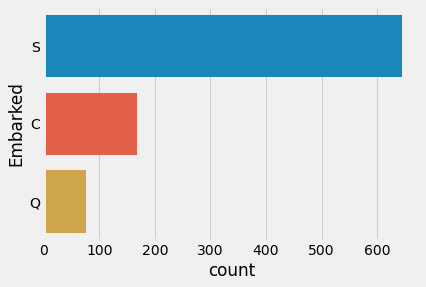

In [53]:
# Viewing the counts
sns.countplot(y= 'Embarked', data= train)

In [54]:
# Add embarked to the sub dataframes
df_con['Embarked'] = train['Embarked']
df_dis['Embarked'] = train['Embarked'] 

In [55]:
# Remove the missing values.
df_con.dropna(subset= ['Embarked'],inplace= True)
df_dis.dropna(subset= ['Embarked'],inplace= True)

In [56]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [57]:
print('df_dis \n',df_dis.head())
print('')
print('')
print('df_con \n',df_con.head())

df_dis 
    Survived  Pclass  Sex  SibSp  Parch               Fare Embarked
0         0       3    0      1      0  (-0.512, 128.082]        S
1         1       1    1      1      0  (-0.512, 128.082]        C
2         1       3    1      0      0  (-0.512, 128.082]        S
3         1       1    1      1      0  (-0.512, 128.082]        S
4         0       3    0      0      0  (-0.512, 128.082]        S


df_con 
    Survived  Pclass     Sex  SibSp  Parch     Fare Embarked
0         0       3    male      1      0   7.2500        S
1         1       1  female      1      0  71.2833        C
2         1       3  female      0      0   7.9250        S
3         1       1  female      1      0  53.1000        S
4         0       3    male      0      0   8.0500        S


## 3. Feature Encoding

Now since our two sub dataframes are ready, we can feature encode them so that they are ready for our machine learning models.
- We will encode our bin dataframe (df_dis) with "One-Hot Encoding" and our continuous dataframe (df_con) with "Label Encoding".

***Discretised Dataframe***

In [58]:
df_dis.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,0,1,0,"(-0.512, 128.082]",S
1,1,1,1,1,0,"(-0.512, 128.082]",C
2,1,3,1,0,0,"(-0.512, 128.082]",S
3,1,1,1,1,0,"(-0.512, 128.082]",S
4,0,3,0,0,0,"(-0.512, 128.082]",S


- One hot encoding is giving a 0 for what the value isnt and a 1 for what it is.

In [59]:
# One Hot Encoded df_dis variables
one_hot_cols = df_dis.columns.tolist()
one_hot_cols.remove('Survived')                             # --> Here we remove Survived because we dont need encode this.
df_dis_enc = pd.get_dummies(df_dis, columns= one_hot_cols)

df_dis_enc.head()

,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,SibSp_0,SibSp_1,SibSp_2,SibSp_3,...,Parch_4,Parch_5,Parch_6,"Fare_(-0.512, 128.082]","Fare_(128.082, 256.165]","Fare_(256.165, 384.247]","Fare_(384.247, 512.329]",Embarked_C,Embarked_Q,Embarked_S
0,0,0,0,1,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
1,1,1,0,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
2,1,0,0,1,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,1,1,0,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
4,0,0,0,1,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1


***Continuous Dataframe***

In [60]:
df_con.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,male,1,0,7.2500,S
1,1,1,female,1,0,71.2833,C
2,1,3,female,0,0,7.9250,S
3,1,1,female,1,0,53.1000,S
4,0,3,male,0,0,8.0500,S


In [61]:
# Label Encoded using LabelEncoder()                         
df_con_enc = df_con.apply(LabelEncoder().fit_transform)

df_con_enc.head(10)

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,2,1,1,0,18,2
1,1,0,0,1,0,207,0
2,1,2,0,0,0,41,2
3,1,0,0,1,0,189,2
4,0,2,1,0,0,43,2
5,0,2,1,0,0,51,1
6,0,0,1,0,0,186,2
7,0,2,1,3,1,124,2
8,1,2,0,0,2,74,2
9,1,1,0,1,0,154,0


## 4. Start Building Maching Learning Models

Before running a ML model our aim was to turn all values to numbers. We will now run a series of machine learning algorithm to see which will yield the best results.

#### Let's seperate the data

In [62]:
# For our simplicity we will be using the continuous dataframe.
selected_df = df_con_enc

In [63]:
# Split the dataframe into features (predictive variables) and labels (target variable).
X_train = selected_df.drop('Survived', axis= 1)      # --> Features
y_train = selected_df['Survived']                    # --> Label   

In [64]:
X_train.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,2,1,1,0,18,2
1,0,0,1,0,207,0
2,2,0,0,0,41,2
3,0,0,1,0,189,2
4,2,1,0,0,43,2


In [65]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In any model building, we mainly focus on 3 main steps:

- Fitting the model and finding the accuracy (accuracy score) of the fitted model.
- Perform K-Fold Cross Validation (K needs to be specified).
- Find the accuracy of the Cross Validation. 

**We will be running a whole bunch of models to figure out which model is best suited for our data.**

#### Model 1: Logistic Regression

In [66]:
start_time = time.time()
algorithm = LogisticRegression()

## Step 1:
model = algorithm.fit(X_train, y_train)      # Creating the model. We will fit the algorithm to the training data.
log_acc = round(model.score(X_train, y_train)*100, 2)

## Step 2:  --> This code performs Cross Validation automatically.
log_train_pred = model_selection.cross_val_predict(algorithm, X_train, y_train, cv= 10, n_jobs= -1)

## Step 3:  --> Cross Validation accuracy metric.
log_acc_cv = round(metrics.accuracy_score(y_train, log_train_pred)*100, 2)

log_time = (time.time()- start_time)

In [67]:
# Logistic Regression
print('Accuracy of the model is: ', log_acc)
print('Accuracy of 10-Fold CV is: ', log_acc_cv)
print('Running time is: ', datetime.timedelta(seconds= log_time))

Accuracy of the model is:  79.42
Accuracy of 10-Fold CV is:  78.18
Running time is:  0:00:16.317096


#### Model 2: K-Nearest Neighbours

In [68]:
start_time = time.time()
algorithm = KNeighborsClassifier()

## Step 1:
model = algorithm.fit(X_train, y_train)      # Creating the model. We will fit the algorithm to the training data.
knn_acc = round(model.score(X_train, y_train)*100, 2)

## Step 2:  --> This code performs Cross Validation automatically.
knn_train_pred = model_selection.cross_val_predict(algorithm, X_train, y_train, cv= 10, n_jobs= -1)

## Step 3:  --> Cross Validation accuracy metric.
knn_acc_cv = round(metrics.accuracy_score(y_train, knn_train_pred)*100, 2)

knn_time = (time.time()- start_time)

In [69]:
# K-Nearest Neighbours
print('Accuracy of the model is: ', knn_acc)
print('Accuracy of 10-Fold CV is: ', knn_acc_cv)
print('Running time is: ', datetime.timedelta(seconds= knn_time))

Accuracy of the model is:  81.44
Accuracy of 10-Fold CV is:  73.68
Running time is:  0:00:01.094592


#### Model 3: Gaussian Naive Bayes

In [70]:
start_time = time.time()
algorithm = GaussianNB()

## Step 1:
model = algorithm.fit(X_train, y_train)      # Creating the model. We will fit the algorithm to the training data.
gnb_acc = round(model.score(X_train, y_train)*100, 2)

## Step 2:  --> This code performs Cross Validation automatically.
gnb_train_pred = model_selection.cross_val_predict(algorithm, X_train, y_train, cv= 10, n_jobs= -1)

## Step 3:  --> Cross Validation accuracy metric.
gnb_acc_cv = round(metrics.accuracy_score(y_train, gnb_train_pred)*100, 2)

gnb_time = (time.time()- start_time)

In [71]:
# Gaussian Naive Bayes
print('Accuracy of the model is: ', gnb_acc)
print('Accuracy of 10-Fold CV is: ', gnb_acc_cv)
print('Running time is: ', datetime.timedelta(seconds= gnb_time))

Accuracy of the model is:  76.72
Accuracy of 10-Fold CV is:  76.38
Running time is:  0:00:00.203821


#### Model 4: Linear Support Vector Machines (SVC)

In [72]:
start_time = time.time()
algorithm = LinearSVC()

## Step 1:
model = algorithm.fit(X_train, y_train)      # Creating the model. We will fit the algorithm to the training data.
svc_acc = round(model.score(X_train, y_train)*100, 2)

## Step 2:  --> This code performs Cross Validation automatically.
svc_train_pred = model_selection.cross_val_predict(algorithm, X_train, y_train, cv= 10, n_jobs= -1)

## Step 3:  --> Cross Validation accuracy metric.
svc_acc_cv = round(metrics.accuracy_score(y_train, svc_train_pred)*100, 2)

svc_time = (time.time()- start_time)

In [73]:
# Linear Support Vector Machines
print('Accuracy of the model is: ', svc_acc)
print('Accuracy of 10-Fold CV is: ', svc_acc_cv)
print('Running time is: ', datetime.timedelta(seconds= svc_time))

Accuracy of the model is:  76.49
Accuracy of 10-Fold CV is:  70.87
Running time is:  0:00:00.708320


#### Model 5: Stochastic Gradient Descent

In [74]:
start_time = time.time()
algorithm = SGDClassifier()

## Step 1:
model = algorithm.fit(X_train, y_train)      # Creating the model. We will fit the algorithm to the training data.
SGD_acc = round(model.score(X_train, y_train)*100, 2)

## Step 2:  --> This code performs Cross Validation automatically.
SGD_train_pred = model_selection.cross_val_predict(algorithm, X_train, y_train, cv= 10, n_jobs= -1)

## Step 3:  --> Cross Validation accuracy metric.
SGD_acc_cv = round(metrics.accuracy_score(y_train, SGD_train_pred)*100, 2)

SGD_time = (time.time()- start_time)

In [75]:
# Stochastic Gradient Descent
print('Accuracy of the model is: ', SGD_acc)
print('Accuracy of 10-Fold CV is: ', SGD_acc_cv)
print('Running time is: ', datetime.timedelta(seconds= SGD_time))

Accuracy of the model is:  59.39
Accuracy of 10-Fold CV is:  65.35
Running time is:  0:00:00.256231


#### Model 6: Decision Tree Classifier

In [76]:
start_time = time.time()
algorithm = DecisionTreeClassifier()

## Step 1:
model = algorithm.fit(X_train, y_train)      # Creating the model. We will fit the algorithm to the training data.
dt_acc = round(model.score(X_train, y_train)*100, 2)

## Step 2:  --> This code performs Cross Validation automatically.
dt_train_pred = model_selection.cross_val_predict(algorithm, X_train, y_train, cv= 10, n_jobs= -1)

## Step 3:  --> Cross Validation accuracy metric.
dt_acc_cv = round(metrics.accuracy_score(y_train, dt_train_pred)*100, 2)

dt_time = (time.time()- start_time)

In [77]:
#  Decision Tree Classifier
print('Accuracy of the model is: ', dt_acc)
print('Accuracy of 10-Fold CV is: ', dt_acc_cv)
print('Running time is: ', datetime.timedelta(seconds= dt_time))

Accuracy of the model is:  92.46
Accuracy of 10-Fold CV is:  79.42
Running time is:  0:00:00.308237


#### Model 7: Gradient Boost Trees

In [78]:
start_time = time.time()
algorithm = GradientBoostingClassifier()

## Step 1:
model = algorithm.fit(X_train, y_train)      # Creating the model. We will fit the algorithm to the training data.
gbt_acc = round(model.score(X_train, y_train)*100, 2)

## Step 2:  --> This code performs Cross Validation automatically.
gbt_train_pred = model_selection.cross_val_predict(algorithm, X_train, y_train, cv= 10, n_jobs= -1)

## Step 3:  --> Cross Validation accuracy metric.
gbt_acc_cv = round(metrics.accuracy_score(y_train, gbt_train_pred)*100, 2)

gbt_time = (time.time()- start_time)

In [79]:
#  Decision Tree Classifier
print('Accuracy of the model is: ', gbt_acc)
print('Accuracy of 10-Fold CV is: ', gbt_acc_cv)
print('Running time is: ', datetime.timedelta(seconds= gbt_time))

Accuracy of the model is:  86.39
Accuracy of 10-Fold CV is:  81.1
Running time is:  0:00:02.673868


#### Model 8: CatBoost Algorithm

This is by a Russian company (Yandex) who created it as an in-house algorithm but now it is open sourced.

- CatBoost is a state-of-the-art open source gradient boosting on decision trees library.
- It is simple and easy to use. 

For more details --> https://catboost.ai/

In [80]:
# View the features for CatBoost model
X_train.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,2,1,1,0,18,2
1,0,0,1,0,207,0
2,2,0,0,0,41,2
3,0,0,1,0,189,2
4,2,1,0,0,43,2


In [81]:
# View the label for CatBoost model
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [82]:
# Define the categorical features for CatBoost model
cat_features = np.where(X_train.dtypes != np.float)[0]
cat_features

array([0, 1, 2, 3, 4, 5], dtype=int64)

In [83]:
# We will use CatBoost Pool() function to pool together the training data and the categorical labels
train_pool = Pool(X_train, y_train, cat_features)

In [84]:
# CatBoost Model definition
catboost_model = CatBoostClassifier(iterations= 1000, custom_loss= ['Accuracy'], loss_function= 'Logloss')

# Fit CatBoost model
catboost_model.fit(train_pool, plot= False)

# CatBoost accuracy
catboost_acc = round(catboost_model.score(X_train, y_train)*100, 2)

l: 53.2s	remaining: 33s
617:	learn: 0.3406828	total: 53.3s	remaining: 33s
618:	learn: 0.3406460	total: 53.4s	remaining: 32.9s
619:	learn: 0.3405365	total: 53.5s	remaining: 32.8s
620:	learn: 0.3405327	total: 53.5s	remaining: 32.7s
621:	learn: 0.3403703	total: 53.6s	remaining: 32.6s
622:	learn: 0.3402574	total: 53.7s	remaining: 32.5s
623:	learn: 0.3397939	total: 53.8s	remaining: 32.4s
624:	learn: 0.3396298	total: 53.9s	remaining: 32.3s
625:	learn: 0.3394994	total: 54s	remaining: 32.2s
626:	learn: 0.3392936	total: 54s	remaining: 32.1s
627:	learn: 0.3392192	total: 54.1s	remaining: 32s
628:	learn: 0.3391045	total: 54.2s	remaining: 31.9s
629:	learn: 0.3389829	total: 54.3s	remaining: 31.9s
630:	learn: 0.3388442	total: 54.4s	remaining: 31.8s
631:	learn: 0.3387292	total: 54.5s	remaining: 31.7s
632:	learn: 0.3387281	total: 54.5s	remaining: 31.6s
633:	learn: 0.3386477	total: 54.6s	remaining: 31.5s
634:	learn: 0.3384845	total: 54.6s	remaining: 31.4s
635:	learn: 0.3383609	total: 54.7s	remaining: 31

In [85]:
# CatBoost Cross Validation
start_time = time.time()

# Set the parameters for cross validation as same as the initial model
cv_param = catboost_model.get_params()

# Run 10-Folds CV
cv_data = cv(train_pool, cv_param, fold_count= 10, plot= False)

# How long does it take?
catboost_time = (time.time()- start_time)

# CatBoost results get saved into a dataframe,the maximum accuracy score is
catboost_acc_cv = round(np.max(cv_data['test-Accuracy-mean'])*100, 2)

83	best: 0.4289882 (172)	total: 13m 33s	remaining: 3m 44s
784:	learn: 0.2168138	test: 0.4550408	best: 0.4289882 (172)	total: 13m 35s	remaining: 3m 43s
785:	learn: 0.2166222	test: 0.4552051	best: 0.4289882 (172)	total: 13m 36s	remaining: 3m 42s
786:	learn: 0.2165048	test: 0.4553259	best: 0.4289882 (172)	total: 13m 37s	remaining: 3m 41s
787:	learn: 0.2163561	test: 0.4553438	best: 0.4289882 (172)	total: 13m 38s	remaining: 3m 40s
788:	learn: 0.2162252	test: 0.4552910	best: 0.4289882 (172)	total: 13m 39s	remaining: 3m 39s
789:	learn: 0.2161409	test: 0.4552856	best: 0.4289882 (172)	total: 13m 40s	remaining: 3m 38s
790:	learn: 0.2160367	test: 0.4553204	best: 0.4289882 (172)	total: 13m 41s	remaining: 3m 37s
791:	learn: 0.2159389	test: 0.4553692	best: 0.4289882 (172)	total: 13m 42s	remaining: 3m 36s
792:	learn: 0.2158280	test: 0.4554286	best: 0.4289882 (172)	total: 13m 44s	remaining: 3m 35s
793:	learn: 0.2156997	test: 0.4554253	best: 0.4289882 (172)	total: 13m 45s	remaining: 3m 34s
794:	learn: 

- In order the view the plots try running in Jupyter and put 'plot= True'. This code was done in VS Code. 

In [86]:
#  CatBoost Algorithm
print('Accuracy of the model is: ', catboost_acc)
print('Accuracy of 10-Fold CV is: ', catboost_acc_cv)
print('Running time is: ', datetime.timedelta(seconds= catboost_time))

Accuracy of the model is:  88.08
Accuracy of 10-Fold CV is:  81.32
Running time is:  0:17:47.349653


### Model Results

Now let's see which model has the best cross-validation accuracy.

- <b>NOTE:</b> We care more about the accuracy of cross validation, as the metrics we get from the model can randomly score higher than usual.

In [87]:
cv_models = pd.DataFrame({'Model':[' Logistic Regression', 'K-Nearest Neighbours', 'Gaussian Naive Bayes', 
                                'Linear Support Vector Machines (SVC)', 'Stochastic Gradient Descent', 
                                'Decision Tree Classifier', 'Gradient Boost Trees', 'CatBoost Algorithm'],
                      'Score':[log_acc_cv, knn_acc_cv, gnb_acc_cv, svc_acc_cv, SGD_acc_cv, dt_acc_cv, gbt_acc_cv,
                               catboost_acc_cv]})

print('Cross-Validation Accuracy Scores')
cv_models.nlargest(8,'Score')

Cross-Validation Accuracy Scores


,Model,Score
7,CatBoost Algorithm,81.32
6,Gradient Boost Trees,81.10
5,Decision Tree Classifier,79.42
0,Logistic Regression,78.18
2,Gaussian Naive Bayes,76.38
1,K-Nearest Neighbours,73.68
3,Linear Support Vector Machines (SVC),70.87
4,Stochastic Gradient Descent,65.35


> We can see that CatBoost model has the best result. Since guessing would give us 50% accuracy (0 or 1), getting under 82% is pretty good.

- Cross Validation is more robust than the .fit() model as it does multiple passes over the data instead of one.

### Feature Importance

According to our model which were the features that impacted the survival of passengers onboard Titanic.

In [88]:
# Feature Importance

def feature_importance(model, data):
    fea_imp = pd.DataFrame({'imp':model.feature_importances_, 'col':data.columns})
    fea_imp = fea_imp.nsmallest(10,'imp')
    visual = fea_imp.plot(kind= 'barh', x= 'col', y= 'imp', figsize=(20,10))
    return fea_imp

,imp,col
2,10.766248,SibSp
5,12.975727,Embarked
3,13.595283,Parch
4,16.272008,Fare
0,21.919278,Pclass
1,24.471455,Sex


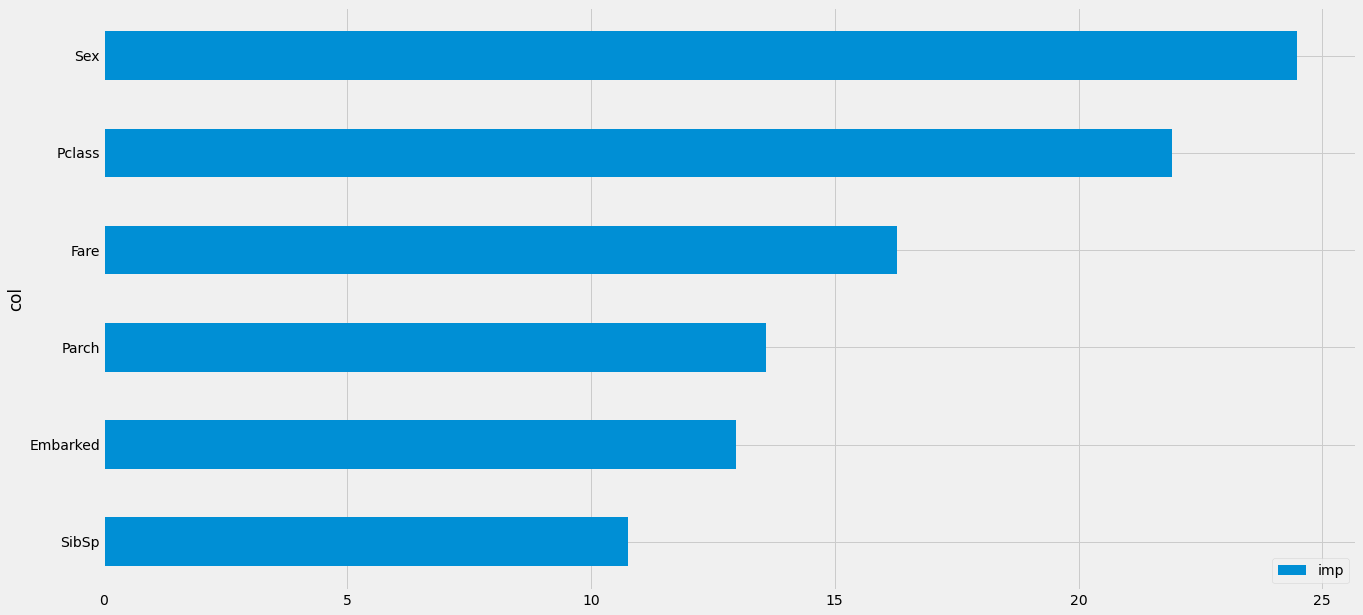

In [89]:
# Plot feature importance scores
feature_importance(catboost_model, X_train)

#### Why would you want feature importance?

Feature importance shows how much each feature contributed to the model.

We could take this information and remove features which don't contribute much to reduce dimenstionality (and save compute).

Feature importance figures also show people who may not be familiar with the problem what features of their data are most important when it comes to making predictions with machine learning models.

## 5. Precision and Recall

Precision and Recall are metrics that you use when you have an imbalanced classification problem.

- Recall - a metric which measures a models ability to find all relevant cases in a dataset.
- Precision - a metric which measures a models ability to correctly identify only relevant cases.

Combining  Precision and Recall gives us the **F1 score.**

They fall between 0 and 1, with 1 being better.

In [90]:
metrics = ['Precision', 'Recall', 'F1', 'AUC']

eval_metrics = catboost_model.eval_metrics(train_pool, metrics= metrics, plot= False)

for metric in metrics:
    print(str(metric)+ ': {}' .format(np.mean(eval_metrics[metric])))

Precision: 0.8895629218329411
Recall: 0.7111264705882352
F1: 0.7898709737285132
AUC: 0.9093503562627238


> **Recall = TP/(TP + FN)**
- Here the Recall is pretty low. This means that there is a higher amount of False Negatives (predicting 'Did not survive' when it is actually 'Survived').

> **Pression = TP/(TP + FP)**
- Precision is high. Thus, we can say say that there is less false positives (predicting 'Survived' when it is actually 'Did not survived')

## 6. Prediction on the Test dataset

Let's use the model with the highest cross-validation accuracy score to make a prediction on the test dataset.

We want to make predictions on the same columnns our model is trained on.

So we have to select the subset of right columns of the test dateframe, encode them and make a prediciton with our model.

In [91]:
X_train.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,2,1,1,0,18,2
1,0,0,1,0,207,0
2,2,0,0,0,41,2
3,0,0,1,0,189,2
4,2,1,0,0,43,2


In [92]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [93]:
# Create a list of columns to be used for predictions.
wanted_columns = X_train.columns
wanted_columns

Index(['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

In [94]:
# Make predictions using CatBoost model on wanted columns.
predictions = catboost_model.predict(test[wanted_columns].apply(LabelEncoder().fit_transform))

In [95]:
# Our predictions array is comprised of 0's and 1's (Survived or Did Not Survive).
predictions[:20]

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1],
      dtype=int64)

In [96]:
# Create a dataframe and append the relevant colimns.
submission = pd.DataFrame()
submission['Passenger ID'] = test['PassengerId']
submission['Survived'] = predictions
submission.head(10)

,Passenger ID,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [97]:
# What did our submission have to look like?
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [98]:
# Are our test and submission the same length?
if len(submission) == len(test):
    print('The submission and the test dataframes are of the same length')
else:
    print('Dataframes mismatched')

The submission and the test dataframes are of the same length


In [99]:
# convert submission dataframe to csv.
submission.to_csv('DATA/TITANIC/final_submission.csv', index= False)
print('Submission csv is ready')

Submission csv is ready


In [100]:
# Checking the final submission csv.
final_submission = pd.read_csv('DATA/TITANIC/final_submission.csv')
final_submission.head(20)

,Passenger ID,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


## REFERENCES

- https://youtu.be/f1y9wDDxWnA - Daniel Bourke has expalined in a clear and well manner on how to go through this project. He has also provided his github, which is really helpful.

- https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c - This article will give a clear understanding of what Precision and Recall is.

## Challenges

a. What is an outlier?

> Suppose consider the above graph. Here let us imagine that there is a single value 10 that is towards the far right. Now this value doesnt make sense as all the remaining data is in one corner. Thus that value acts as an outlier which can cause problems to our analysis. Most of the times we remove such values.

b. What is the difference between Nominal and Ordinal variable
> If the categories are not ranked its a Nominal variable. If they are ranked it is an Ordinal variable.

c. Can we create a new column in our subset dataframe, which takes in the value Mr, Mrs and all and assigns it some number?

d. Understand the graph subplots.